This notebook will go over multivariate time series forecasting methods like SARIMAX, XGBoost and DNNs (specifically LSTM networks)

Imports

In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as datetime
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb

With the SARIMA model without using exogenous variables we were able to produce a relatively accurate model for forecasting but now we will try with exogenous variables and try multivariate forecasting

In [122]:
df = pd.read_csv('../data/Grouped_Walmart_Sales.csv')

In [123]:
def calculate_mape(x_test, forecast):
    mape = 100 * np.mean(np.abs((x_test - forecast) / x_test))
    return mape

In [124]:
X = df[['holiday_flag', 'temperature', 'cpi', 'unemployment']]
y = df['weekly_sales']
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [125]:
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [126]:
predictions = model.predict(X_test)

In [127]:
print(calculate_mape(y_test, predictions))

29.41810645633998


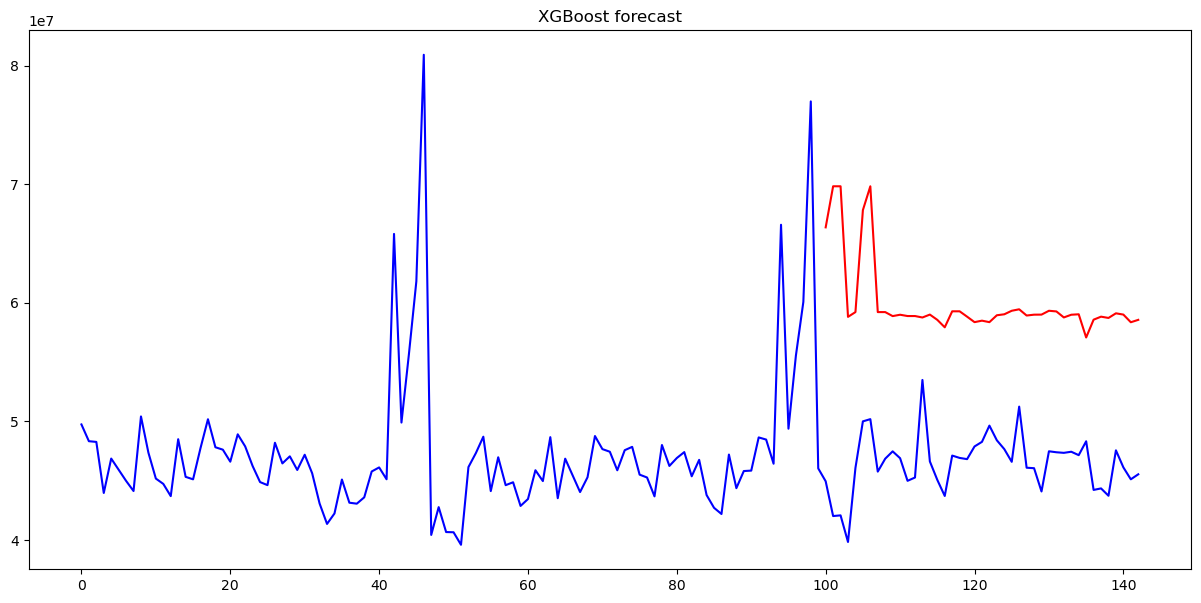

In [128]:
plt.figure(figsize=(15, 7))
plt.plot(df['weekly_sales'], label='Actual', color='blue')
plt.plot(X_test.index, predictions, label='XGBoost Forecast', color='red')
plt.title("XGBoost forecast")
plt.show()

The XGBoost does not perform well with just these base features so we can implement lag features and moving average features to improve forecasting accuracy.

In [129]:
for lag in [1, 2, 3, 4, 52]:
    df[f'lag_{lag}'] = df['weekly_sales'].shift(lag)

df['rolling_3'] = df['weekly_sales'].shift(1).rolling(window=3).mean()
df['rolling_8'] = df['weekly_sales'].shift(1).rolling(window=8).mean()
df = df.dropna()
X = df[['holiday_flag', 'temperature', 'cpi', 'unemployment', 
         'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_52', 
         'rolling_3', 'rolling_8']]
y = df['weekly_sales']

In [130]:
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [131]:
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [132]:
print(calculate_mape(y_test, predictions))

4.345584722214733


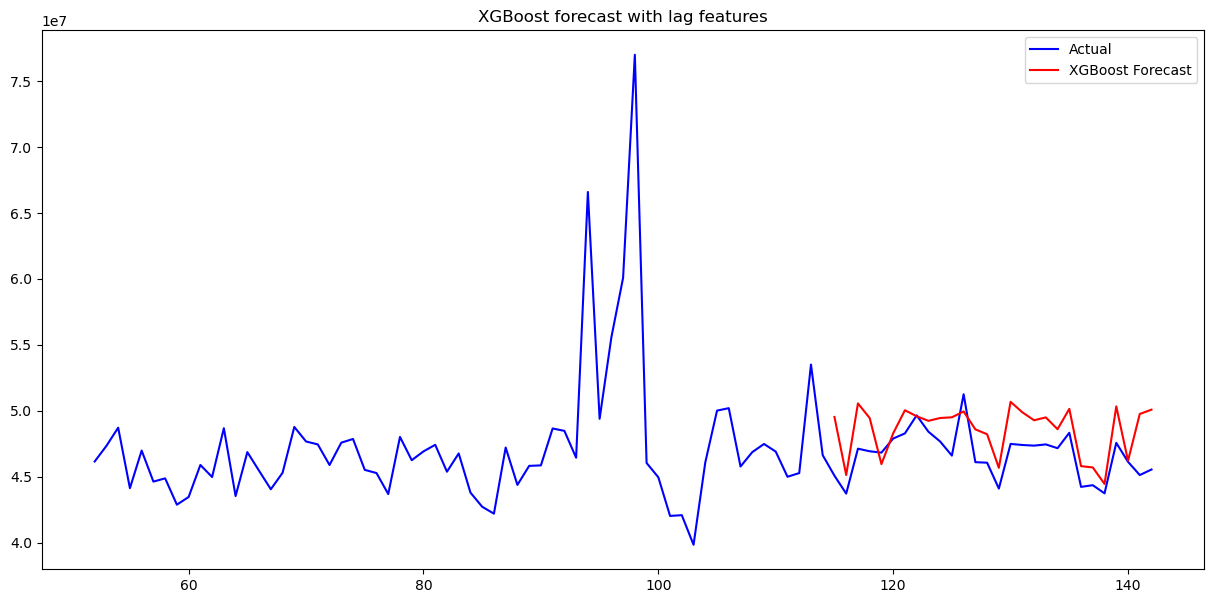

In [133]:
plt.figure(figsize=(15, 7))
plt.plot(df['weekly_sales'], label='Actual', color='blue')
plt.plot(X_test.index, predictions, label='XGBoost Forecast', color='red')
plt.title("XGBoost forecast with lag features")
plt.legend()
plt.show()